In [1]:
using Random
using Random123
using Distributions
#using BenchmarkTools
using Plots
using StatsPlots
using StatsBase
using Statistics
using DataFrames
#using Vega
#using PyCall
rng_default = Xoshiro(100)
Random.seed!(rng_default, 100)

Xoshiro(0x052a102ac036e740, 0x0271411b7855150e, 0xcad97eaaad79420a, 0x379cde0a3a63c93c, 0x88075f1a254ef140)

In [56]:
"""
We now represent genotypes (with potentially different genomes) and their size
"""
mutable struct genotype
    
    genotype::BigInt # base 10 representation of the genotype (up to UInt128)
    genome::BigInt # The binary number representing the latent/active status of each locus on the full landscape (UInt128)
    size::AbstractFloat # number of individuals with the genotype
    fitness::AbstractFloat

    function genotype(genotype, genome, size, fitness) # inner constructor to redefine fitness based on provided genotype
        fitness::AbstractFloat = get_fitness(genotype, genome, additive_effects, σ_epi, model, calculation) # these parameters are passed in from the global scope
        return new(genotype, genome, size, fitness)
    end
end

"""
Generates a vector of locus-wise effects, with bounds depending on the type of calculation used for the additive fitness effects
"""
function generate_additive_effects(loci::Int, calculation = "exponential")
    if calculation == "additive" || calculation == "exponential"
        return rand(rng_default, Normal(0, 1), loci)
    elseif calculation == "multiplicative"  
        return rand(rng_default, Truncated(Normal(0, 1), -1, Inf), loci)
    end
end

"""
Takes a base10 genotype, loci present in genome, and other fitness landscape params, and returns the calculated fitness value.\n
Utilizes the cbrng to efficiently and reproducibly find the fitness of a genotype on a landscape
"""
function get_fitness(genotype::UInt128, genome::UInt128, additive_effects, σ_epi, model, calculation)
    # optional to pass in some model parameters here. start with rmf: μ_add, σ_add, σ_epi, additive_effects
    rng_cbrng = ARS1x(genome) # seed the CBRNG with the genome
    if model == "rmf"
        set_counter!(rng_cbrng, genotype) # set the index of the cbrng counter to the base10 genotype (prepare to retrieve its fitness)
        μ_epi::Float64 = 0 # I believe this is default in the rmf model
        epistatic_component = rand(rng_cbrng, Normal(μ_epi, σ_epi)) # we can indeed use a random sample of the normal distribution
        if calculation == "additive"
            additive_component = sum(digits(genotype, base = 2, pad = loci) .* additive_effects) # additive effects need to be defined outside, in global scope, and passed in
            return abs(additive_component + epistatic_component)
        elseif calculation == "multiplicative"
            additive_component = prod(1 .+ (digits(genotype, base = 2, pad = loci) .* additive_effects))
            return additive_component .* (1 + epistatic_component)
        elseif calculation == "exponential" # the base used in this calculation determines the tailedness of the distribution of initial fitnesses. default with ℯ
            additive_component = exp(sum(digits(genotype, base = 2, pad = loci) .* additive_effects))
            return additive_component * exp(epistatic_component)
        end
    end
end

"""
Function to flip a bit k (from the binary representation) within a base 10 number x and return in base 10\n  
this enables us to avoid working in binary and hopefully avoid binary<>base10 conversions
"""
function flip_bit(x::T, k::Int) where T <: Unsigned
    #return (x + (-1)^(floor(x/(2^(k-1))))*2^(k-1)) # Stephan's original solution
    return x .⊻ one(T) << (k-1) # a method by left-bitshifting and xor preserves type/bitwidth
end

"""
Function to determine if, how many, and which mutants a population of genotype will generate
"""
# nonononono move this to a per base per generation rate. otherwise the logic becomes completely fucked
# we now pass in a population tuple (genotype, genome) for each in the current simulation
function generate_mutants!(population::Tuple, current_populations::Dict, μ::AbstractFloat, M::AbstractFloat, loci::Int)
    #num_mutants = count(x -> x, rand(rng_default, floor(Int, genotype_dictionary[genotype].size)) .<= mutation_rate) # generate n random samples [0,1] for population size n. count the number that are lower than the mutation rate, and 'queue' these to mutate
    Random.seed!(100)
    genotype = population[1]
    genome = population[2]
    for i in 1:current_populations[population].size # fetch the number of individuals in this population and do for each individual:
        #μ = 0.01 # per-locus mutation rate
        #M = 0.003 # per-locus genome evolution rate
        #loci = 100
        new_genome = genome # in case we need to make multiple genome mutations sequentially - this enables, potentially, backmutation
        new_genotype = genotype
        active_genome_bits = findall(x -> x == true, digits(new_genome, base = 2, pad = 128))
        # so now we try this for the number of active loci, not the per-individual rate
        events = [rand(rng_default, Binomial(loci, μ)), rand(rng_default, Binomial(loci, M))] # the number and type of events in the genotype and genome to simulate
        #How do we get the remaining events (mutations and expansions) to play in a random order?
        while sum(events) > 0
            mutation_type = rand(rng_default, Bernoulli(events[2]/sum(events)))[1] # generates 0 for mutations, and 1 for genome events
            if mutation_type == true && events[2] > 0 # if there is a genome event generated:
                new_genome = flip_bit(new_genome, rand(rng_default, 1:loci)) # there are no constraints on which loci may become active or not
                active_genome_bits = findall(x -> x == true, digits(new_genome, base = 2, pad = 128)) # and then update the active bits possible for mutations
                new_genotype *= new_genome # reset loci in the genotype to 0 if they are 0 in the genome. Otherwise fitness calc will be incorrect
                events[2] -= 1
            elseif mutation_type == false && events[1] > 0 # else if there is a mutation event generated
                new_genotype = flip_bit(new_genotype, sample(rng_default, active_genome_bits)) # however, we must constrain the flipping of genotype bits based on which loci in the genotype are active
                events[1] -= 1
            end
            println(events, "\n", events ./ sum(events))    
        end
        haskey(current_populations, (new_genotype, new_genome)) ? current_populations[(new_genotype, new_genome)].size += 1 : current_populations[(new_genotype, new_genome)] = genotype(new_genotype, new_genome, 1, Int)
        current_populations[(new_genotype, new_genome)].size -= 1 # remove said mutant from its old genotype
    end
    return nothing
end

"""
Function to simply calculate the hamming distance (this will probably be useful at some point)\n  
TODO: pivot to only base10 representations ([perhaps using this paper?](https://arxiv.org/pdf/1203.4547))
"""
function hamming_dist(genotype_1::BigInt, genotype_2::BigInt, loci::Int) 
    return sum(digits(genotype_1, base = 2, pad = loci) .⊻ digits(genotype_2, base = 2, pad = loci)) # xor the two
end

"""
Function to calculate the average hamming distance between all genotypes in a sample vector
"""
function average_hamming_dist(genotypes::Vector{BigInt}, loci::Int)
    n = length(genotypes)
    total_distance = 0
    pair_count = 0

    # hamming distances for all pairs
    for i in 1:n
        for j in i+1:n  # only compute for unique pairs
            total_distance += sum(digits(genotypes[i], base = 2, pad = loci) .⊻ 
                                  digits(genotypes[j], base = 2, pad = loci))
            pair_count += 1
        end
    end
    return total_distance / pair_count
end

"""
Function to apply the Heaviside step function to a number
"""
function heaviside(num::AbstractFloat)
    return 0.5 * (sign(num) + 1)
end

heaviside

In [373]:
@doc hamming_dist

# getfield(Main, Symbol("hamming_dist"))([function_args])

Function to simply calculate the hamming distance (this will probably be useful at some point)

TODO: pivot to only base10 representations ([perhaps using this paper?](https://arxiv.org/pdf/1203.4547))


In [57]:
# Initializing all our relevant parameters
loci = 5
init_active_loci = 3
total_population = 100
num_genotypes = 1
σ_epi::Float64 = 1 # standard deviation of the epistatic effects
μ = (total_population^-1) # Mutation rate of the genotypes with some genome. For simplicity, we make on average 1 'individual' on the landscape mutate per time step ('generation')
M = μ*10^-1 # rate of genome evolution. expansion/streamlining events happen an order of magnitude less, on average, than mutations
simulation_length = 2
model = "rmf"
calculation = "exponential"
Random.seed!(rng_default, 100) # makes the generation of additive effects reproducible
additive_effects = generate_additive_effects(loci, calculation)
genotype_dictionary = Dict{Tuple, genotype}() # keys are stored as a tuple of the genotype(integer) and its genome, and the genotype object as values
df_genotypes = DataFrame(Step = 0) # tracking population counts for summary metrics



# Initialize the starting genome(landscape) - this is the first seed genome
init_genome::UInt128 = 0
Random.seed!(rng_default, 100)
bits_to_flip = sample(rng_default, 1:loci, init_active_loci, replace = false) # generate a vector of unique loci to unlock at start
for locus in bits_to_flip
    init_genome = flip_bit(init_genome, locus) # flip them, while retaining UInt128 - this is important as to not lose any information about the latent genome space!
end
println("Initial Genome: ", init_genome, " \n\t with active bits:", bits_to_flip)

# Initialize genotypes on the landscape
for i in 1:num_genotypes
    # we need a new way of generating random genotypes on a restricted landscape
    Random.seed!(rng_default, 100) # makes the generation of initial genotypes reproducible
    init_genotype::UInt128 = 0 # assume it exists as a 128bit, since it's the max size and it gets cast to this in the cbrng anyway
    for locus in sample(rng_default, bits_to_flip, rand(rng_default, 0:length(bits_to_flip)), replace = false)  # generate a *random number* of bits that are active in the initial genome to be flipped
        init_genotype = flip_bit(init_genotype, locus)
    end
    # init_genotype::BigInt = rand(rng_default, 0:(big"2"^loci)-1) # julia is 1 indexed but genotype space is 0 indexed!!!!! Remember this!!!!!
    (init_genotype, init_genome) ∉ keys(genotype_dictionary) ? #check for a unique genotype-genome pair and make the entry in dict if not
        genotype_dictionary[(init_genotype, init_genome)] = genotype(init_genotype, init_genome, total_population/num_genotypes, Int) : # fitness is the fourth value passed to genotype() and is initally represented as an arbitrary Int before fitness assignment in the constructor
        genotype_dictionary[(init_genotype, init_genome)].size += total_population/num_genotypes # otherwise increment the genotype that already exists
        
    if "Id" ∉ names(df_genotypes) # tracking population counts
        insertcols!(df_genotypes, :Id => init_genotype, :Genome => init_genome, :Pop => genotype_dictionary[(init_genotype, init_genome)].size, makeunique = true)
    elseif "Id" ∈ names(df_genotypes) && init_genotype ∉ df_genotypes[!, :Id]
        push!(df_genotypes, (Step = 0, Id = init_genotype, Genome = init_genome, Pop = genotype_dictionary[(init_genotype, init_genome)].size))
    elseif "Id" ∈ names(df_genotypes) && init_genotype ∈ df_genotypes[!, :Id]
        df_genotypes.Pop[df_genotypes.Id .== init_genotype] .+= total_population/num_genotypes # otherwise increment the genotype that already exists
    end
end

data = [(Symbol(key[1]), value.genome, value.size, value.fitness) for (key, value) in genotype_dictionary] # Construct dataframe out of dictionary information
df_init_landscape = sort!(DataFrame(data, [:Genotype, :Genome, :Size, :Fitness]), [:Fitness, :Size], rev = [true, true]) # sort by reversing fitness then population size values

landscape_size = string(big"2"^loci)
println("Landscape Initialized:\n\tLandscape Size: ", landscape_size[1],".",landscape_size[2],"E",length(landscape_size)-1, "\n\tMax Additive Component: ", exp(sum(max.(additive_effects, 0))), "\n\t", first(df_init_landscape, 10)) # dict.keys actually returns the hash table, not the assigned keys themselves



# Simulate
for t in 1:simulation_length
    print("\rIteration: $t")

    # generate mutants
    current_genotypes = deepcopy(keys(genotype_dictionary)) # avoiding a mutate over iterable issue
    for population in current_genotypes
        generate_mutants!(population, genotype_dictionary, μ, M, loci)
    end
        
    # reassign population sizes based on fitness
    w_bar = sum([((genotype.size / total_population) * genotype.fitness) for genotype in values(genotype_dictionary)])
    probability_vector = [((genotype.size / total_population) * (genotype.fitness / w_bar)) for genotype in values(genotype_dictionary)]
    value_vector = [genotype.g for genotype in values(genotype_dictionary)] # need this to map the multinomial sampling back to genotype sizes
    new_sizes = rand(rng_default, Multinomial(total_population, probability_vector)) # the new genotype sizes, obtained through multinomial sampling
    for i in 1:length(value_vector)
        # since the output from multinomial sampling is in the order of the probability vector passed in, we can index 
        # the sampling output the same as the values vector
        genotype_dictionary[value_vector[i]].size = new_sizes[i] 
    end
        
    # update dataframe and prune genotypes from dictionary
    for genotype in keys(genotype_dictionary)
        if genotype_dictionary[genotype].size == 0
            delete!(genotype_dictionary, genotype)
        else
            push!(df_genotypes, (Id = genotype, Step = t, Pop = genotype_dictionary[genotype].size))
        end
    end
end

data = [(Symbol(genotype), value.size, value.fitness) for (genotype, value) in genotype_dictionary]
df_final_landscape = sort!(DataFrame(data, [:Genotype, :Size, :Fitness]), [:Fitness, :Size], rev = [true, true])

println("\n\nFinal Landscape:\n\t", df_final_landscape)
#

Initial Genome: 11 
	 with active bits:[1, 2, 4]
Landscape Initialized:
	Landscape Size: 3.2E1
	Max Additive Component: 27.278639140545366
	1×4 DataFrame
 Row │ Genotype  Genome  Size     Fitness 
     │ Symbol    BigInt  Float64  Float64 
─────┼────────────────────────────────────
   1 │ 0             11    100.0  2.79218
Iteration: 1[0, 0]
[NaN, NaN]


LoadError: MethodError: objects of type UInt128 are not callable
The object of type `UInt128` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

In [280]:
bits_to_flip
sample(rng_default, bits_to_flip, rand(rng_default, 0:length(bits_to_flip)), replace = false)

Int64[]

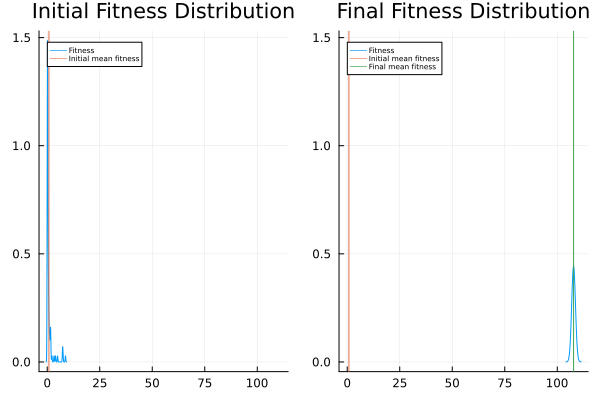

In [4]:
p1 = density(df_init_landscape.Fitness, title = "Initial Fitness Distribution", labels = "Fitness") # two different ways of calling column vector values
vline!([mean(df_init_landscape.Fitness)], label = "Initial mean fitness")
p2 = density(df_final_landscape[:,:Fitness], title = "Final Fitness Distribution", labels = "Fitness")
vline!([mean(df_init_landscape.Fitness)], label = "Initial mean fitness") 
vline!([mean(df_final_landscape.Fitness)], label = "Final mean fitness")
plot(p1, p2, layout = (1,2), legend = :topleft, legendfontsize = 5, link = :all)
#png("100l_fitnesses.png")
#plot(p1)

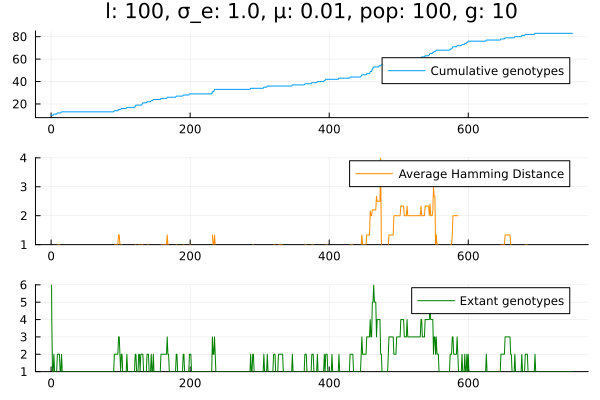

In [12]:
genotype_counts = countmap(df_genotypes.Step) # obtain dict of counts for each time step (= number of genotypes at that step)
df_counts = sort!(DataFrame([:Step => collect(keys(genotype_counts)), :Count => collect(values(genotype_counts))]), :Step) # make into a dataframe and sort by step
unique_counts = countmap(unique(df_genotypes, :Id).Step) # do the same but only for unique genotypes
df_unique_counts = sort!(DataFrame([:Step => collect(keys(unique_counts)), :Count => collect(values(unique_counts))]), :Step)
df_full_steps = DataFrame(Step = minimum(df_unique_counts.Step):maximum(df_counts.Step))
leftjoin!(df_full_steps, df_unique_counts, on = :Step)
df_full_steps[!, :Count] = coalesce.(df_full_steps.Count, 0)
df_full_steps[!,:Cumulative] = cumsum(df_full_steps.Count) # calculate the cumulative sum over Count
mu = round(mutation_rate, sigdigits = 3)
p3 = plot(df_counts.Step, df_full_steps.Cumulative, legend = :right, label = "Cumulative genotypes", title = "l: $loci, σ_e: $σ_epi, μ: $mu, pop: $total_population, g: $num_genotypes")
df_hamming_diversity = combine(groupby(df_genotypes, :Step), :Id => (group -> average_hamming_dist(collect(group), loci)) => :AverageHammingDistance)
p3_1 = plot(df_hamming_diversity[1:end,:Step], df_hamming_diversity[1:end,:AverageHammingDistance], label = "Average Hamming Distance", ylim = (1,4), legend = :topright, color = :darkorange)
p3_2 = plot(df_counts[1:end,:Step], df_counts[1:end,:Count], ylim = (1,6), legend = :topright, label = "Extant genotypes", color = :green) 
plot(p3, p3_1, p3_2, layout = (3,1))
#png("l_15_10_genotypes.png")

In [14]:
# Create stacked area plot to show genotype fractions over time
df_genotypes_unstacked = unstack(df_genotypes, :Id, :Pop, fill = 0.0)
x = df_genotypes_unstacked.Step
y_values = select(df_genotypes_unstacked, Not(:Step)) |> Matrix
p4 = plot(x, y_values, fill_between = true, title = "l: $loci, σ(epistatic): $σ_epi, μ: $mu, pop: $total_population, g: $num_genotypes", xlabel = "Time", ylabel = "Population", label = :none, palette = :tab20, alpha = 0.5)
png("l_100_interference_stackplot.png")

"l_100_interference_stackplot.png"

In [18]:
"""
Function to return the average expected (worst-case) time for a genotype to find a higher fitness peak\n
&emsp; i.e. we assume only one mutant is generated per timestep
"""
function expected_searchtime(l::Int64)
    x = 0
    for i in 1:l # calculates H_l, the l-th harmonic number
        x += 1/i
    end
    expectation = x *= l
    stdev = sqrt(((π^2 * l^2)/6)-expectation)
    return expectation, stdev # the expectations of this is then l * H_l 
end

expected_searchtime(loci)

(518.737751763962, 126.21649225326419)

In [268]:
@pyimport pandas as pd
py_df_genotypes = pd.DataFrame(Dict(col => df_genotypes[!, col] for col in names(df_genotypes)))
py_df_tree = pd.DataFrame(Dict(col => df_tree[!, col] for col in names(df_tree)))

py"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyfish import fish_plot, process_data, setup_figure

populations_df = $py_df_genotypes
parent_tree_df = $py_df_tree

data = process_data(populations_df, parent_tree_df)
setup_figure()
fish_plot(*data)
plt.show()
"""


LoadError: UndefVarError: `df_tree` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

j physics 23/4 eco-evo landscapes for additive scaling